<a href="https://colab.research.google.com/github/gabiamorim2/pipeline_telegram/blob/main/projeto_final_pipeline_telegram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto Pipeline de Dados do Telegram**

## **0. Resumo**

O presente projeto foi desenvolvido como **`conclusão`** do curso **Profissão Analista de Dados** da **Escola Britânica de Artes Criativas & Tecnologia** (**`EBAC`**) e tem como objetivo a construção de um ***pipeline de dados em nuvem***. 

O ***pipeline de dados*** foi desenvolvido para ingerir, processar e armazenar mensagens de **texto** disparadas em um grupo no aplicativo de mensagens **Telegram** (o grupo possui usuários reais e foi criado exclusivamente para este trabalho). 

Junto ao grupo foi adicionado um **`bot`**, criado dentro da própria plataforma, responsável por captar as mensagens e encaminha-lás via **API** para a plataforma *cloud* **Amazon Web Services (AWS)**, onde as mensagens foram processadas, armazenadas, limpas e analisadas.

A imagem abaixo demonstra o fluxo do ***pipeline***, ela foi criada e disponibilizada para uso dos alunos, pelo professor responsével pelo curso André Perez.

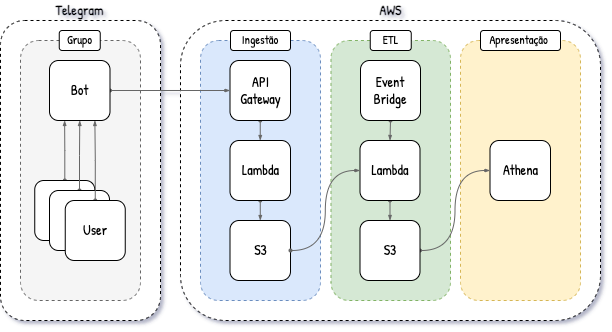

## **1. Contexto**

### **1.1 Chatbots**

O **`chatbot`** é uma aplicação de software que utiliza **Inteligência Artificial (IA)** e processamento de **Linguagem Natural (NLP)** para ajudar seus utilizadores a interagir com as aplicações ou serviços Web através de texto, imagens gráficas ou voz. Os **`chatbots`** compreendem linguagem humana natural, simulam uma conversação humana e executam tarefas simples automatizadas. Eles podem ser desenvolvidos para comandos simples ou para servir de agentes interativos e assistentes digitais complexos.

 - **Porquê utilizar `chatbots`?**
  - Resolução de problemas de suporte a cliente e esclarecimento de dúvidas recorrentes;
  - Acelerar ciclos de vendas, gerando mais oportunidades potenciais e melhorando a fidelização dos clientes;
  - Criando experiências de utilizador personalizadas que se traduzem em clientes mais mais envolvidos e satisfeitos, bem como maiores taxas de conversão;


 - **`Chatbots` transacionais**
  - Tem como único objetivo a execução ou automatização de uma tarefa ou função;
  - Utilizam o processamento de linguagem natural para compreender a intenção da consulta do utilizador e gerar respostas automatizadas conversacionais;
  - As interações são treinadas com base em **dados estruturados**, o que os torna muito úteis para empresas que já sabem quais problemas ou ações comuns para os quais os clientes podem precisar de ajuda;
  - Restaurantes, empresas de entrega, bancos e grandes lojas de varejo utilizam `chatbots` transacionais para lidar com perguntas comuns como horário e dia de funcionamento, formas de pagamento, preço da entrega e etc.

**Fonte:** [Microsoft Virtual Agents](https:///powervirtualagents.microsoft.com/pt-pt/what-is-a-chatbot/)

### **1.2 Telegram**

O `Telegram` é um aplicativo de mensagens instantâneas *freeware*, ou seja, distribuído gratuitamente, e em sua maioria, *open source*. É popular entre desenvolvedores por ser pioneiro na implantação da funcionalidade de **criação de `chatbots`**, que por sua vez, permitem a criação de diversas automações. Está disponível para *smartphones* e *tablets* (Android, IOS, Windows phone, Firefox, Ubuntu) e também aplicação *Web*.

### **1.3 Dados**

Os dados presentes neste projeto podem ser divididos em dois tipos: **transacionais** e **analíticos**. Os dados **transacionais** são representados pelas mensagens enviadas por usuários em um grupo no Telegram, e os dados **analíticos** são os dados provenientes dos sistemas transacionais manipulados na etapa de **ETL** (*extraction, transformation and load*).

## **2. Arquitetura**

Este projeto tem como **objetivo** a construção de um ***pipeline* de dados** que processe, armazene e exponha as mensagens e suas informações referentes de um grupo do **Telegram**, para que profissionais da área de Dados possam realizar as análises pertinentes.

Uma atividade de grande interesse para empresas que já utilizam ou pensam em utilizar os `chatbots`, é a análise exploratória dos dados enviados ao `bot`, para responder perguntas como:

  - Qual **horário** os usuários mais acionam o `bot`?
  - Qual **dúvida** ou **problema** mais recorrente?
  - O `bot` está conseguindo esclarecer as **dúvidas**?

A arquitetura proposta é composta por duas partes: **transacional**, representada pelos dados captados no grupo do **Telegram** e a **analítica**, realizada na plataforma **Amazon Web Services (AWS)** onde os dados são processados e analisados. 

A imagem abaixo demonstra todo o **fluxo do *pipeline* de dados**, ela foi construída e cedida para uso pelo professor André Perez.

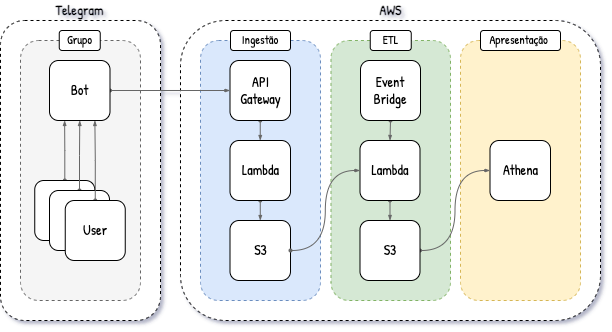




### **2.1 Sistema Transacional**

O `Telegram` representa a fonte de **dados transacionais** deste projeto. Foi criado um grupo de usuários com a presença de um **`bot`**, responsável por capturar as mensagens e redirecioná-las via *webhook* do *backend* do aplicativo para um *endpoint*, exposto pela **API Gateway** (AWS Services). As mensagens trafegam no corpo ou payload da requisição.

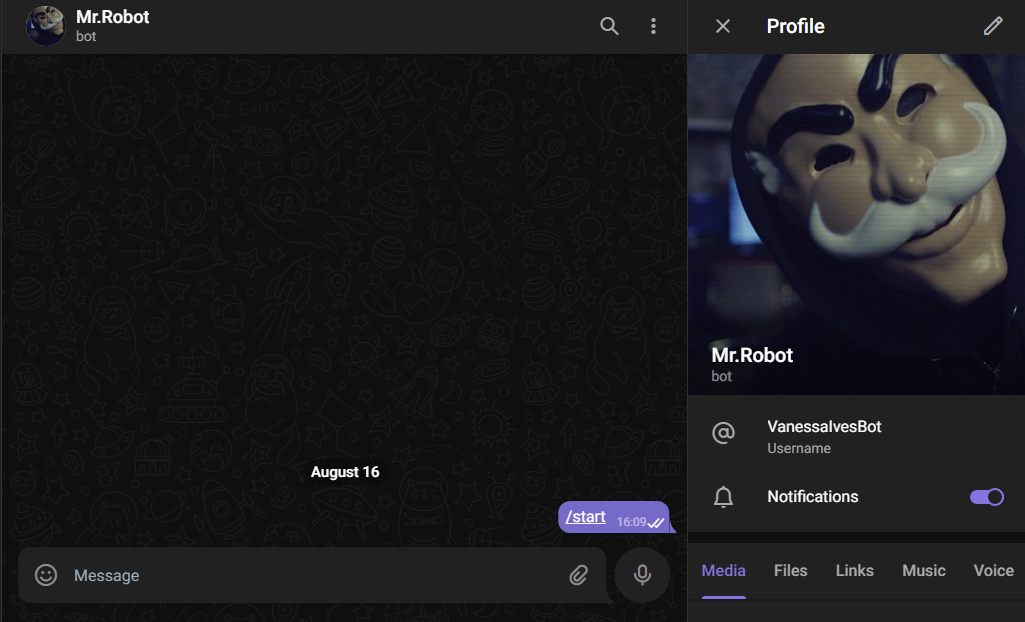

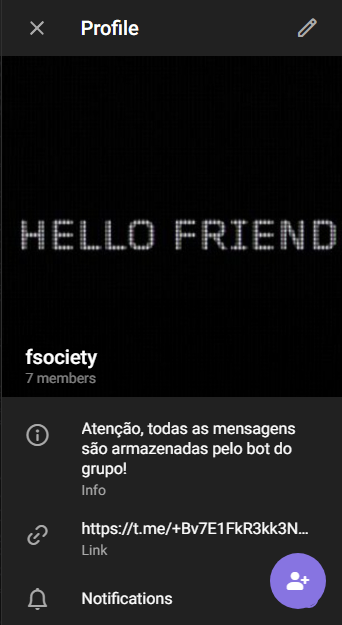

### **2.2 Sistema Analítico**

 A etapa analítica do projeto consiste na **ingestão**, **ETL** (*extract, transform, load*) e **apresentação** dos dados. Ela foi realizada no **Amazon Web Services (AWS)** através dos serviços ***API Gateway*, *Lambda*, *S3*, *EventBridge* e *Athena***.

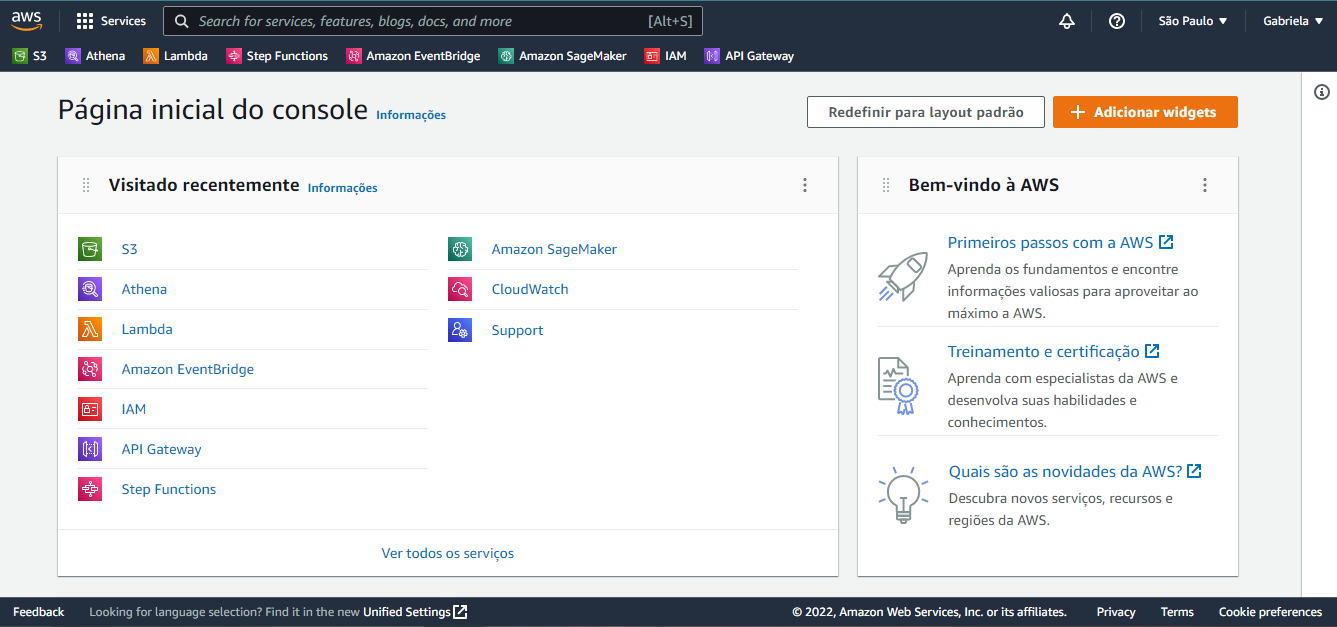

#### **2.2.1.   Ingestão**




A etapa de ingestão é responsável por inserir os dados transacionais no ambiente analítico. Como o **Telegram** retem as mensagens por apenas 24 horas, a ingestão via **streaming** é a mais indicada para este projeto.

Uma requisição **HTTP** com o conteúdo da mensagem em seu *payload* é recebida pelo **AWS API Gateway** que, por sua vez, as redireciona para o **AWS Lambda**, servindo assim como *gatilho*. Já o **AWS Lambda** recebe o *payload* da requisição em seu parâmetro *event*, que salva o conteúdo em um arquivo de formato **JSON** (original) e o armazena em um *bucket* específico no **AWS S3** particionado por dia.

As mensagens capturadas pelo **`bot`** podem ser acessadas via **API**. A única requisição necessária é o `token` fornecido pelo **`botFather`** na criação do **`bot`**. Por isso, começamos com a autenticação abaixo:

In [ ]:
#autenticando o token

from getpass import getpass

token = getpass()

In [ ]:
#pacotes e bibliotecas

import os
import json
import pandas as pd

import logging
from datetime import datetime, timedelta, timezone

import boto3

import pyarrow as pa
import pyarrow.parquet as pq

In [ ]:
# A url base é comum a todos os métodos da API

base_url = f'https://api.telegram.org/bot{token}'

O código abaixo recebe as mensagens do **Telegram** via **API Gateway**, verifica no seu conteúdo se elas foram produzidas no grupo especificado e as escreve em seu formato original **JSON**, em um `bucket` no **AWS S3**.

In [ ]:
def lambda_handler(event: dict, context: dict) -> dict:

  #variáveis de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  #variáveis lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  #código 

  client = boto3.client('s3')
  
  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

Para testar a integração do **AWS Lambda** com a **API**, devemos fazer a implantação da **API** e obter seu endereço `web`. Com a `url` gerada, incluímos ela na variável `aws_api_gateway_url`.

In [ ]:
aws_api_gateway_url = getpass()

 O método **setWebhook** configura o redirecionamento das mensagens captadas pelo `bot` para o endereço `web` do parâmetro `url`, e o método **getWebhookInfo** retorna as informações sobre o `webhook` configurado.

In [ ]:
#setWebhook

response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

In [ ]:
#getWebhookInfo

response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

#### **2.2.2.   ETL**


A etapa de **extração**, **transformação** e **carregamento** é a etapa responsável pela manipulação dos dados extraídos na etapa transacional, ou seja, persistidos em camadas cruas (`raw`) dos sistemas analíticos. O dado `cru` armazenado passa por um processo recorrente onde ele é limpo, duplicado e persistido com técnicas de particionamento, orientado a coluna e compressão. Ao final, o dado está pronto para ser analisado por profissionais da área. 

Uma vez ao dia, o **AWS Event Brigde** aciona o **AWS Lambda** que, por sua vez, processa todas as mensagens geradas no dia anterior (D-1), desnormaliza o dado semi-estruturado típico de arquivos **JSON**, salva o conteúdo processado em um arquivo no formato `Apache Parquet` e o armazena no **AWS S3** particionado por dia.

O código abaixo é executado diariamente pelo **AWS Event Brigde** - em horário pré-estabelecido - para compactar as diversas mensagens que chegam no grupo (do dia anterior), no formato **JSON** armazenadas no `bucket` de dados cru (`raw`), em um único arquivo no formato `Parquet`. Após o processamento, as mensagens são armazenadas no `bucket` de dados enriquecidos (`enriched`).

In [ ]:
def lambda_handler(event: dict, context: dict) -> bool:

  #variáveis de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  #variáveis lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  #código

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None
          
      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  except Exception as exc:
      logging.error(msg=exc)
      return False

Junto ao código acima, temos que adicionar um **laço de repetição** para varrer todas as `chaves` do arquivo e selecionar apenas a `text`, que é a única de interesse deste projeto. Caso a mensagem não possua a chave `text`, ela será criada com o valor `None`.

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

#### **2.2.3.   Apresentação**


Nesta etapa, o **AWS Athena** tem como função apresentar os dados aos usuários e sistemas, através de uma interface **`SQL`**. Portanto, é necessário a criação de uma **tabela externa** sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida (`enriched`) - entregando assim dados mais consistentes e com consultas mais baratas.

A tabela foi criada com a seguinte **`query`**:

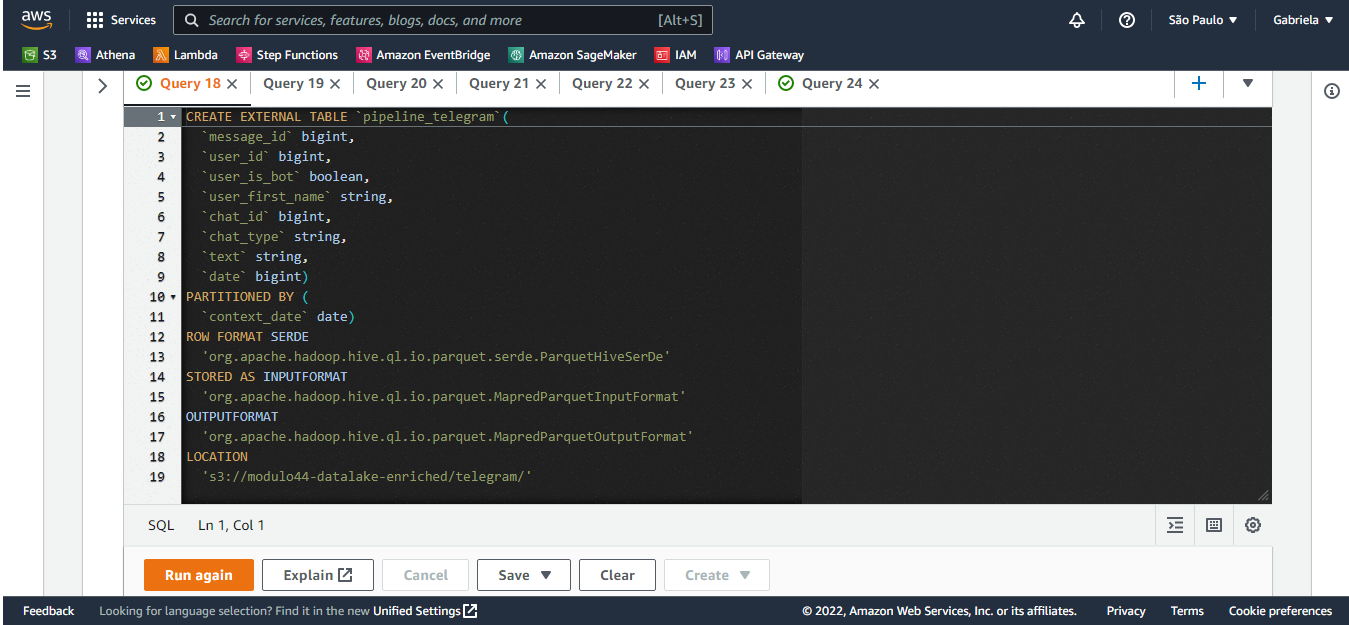

Após a criação da tabela, é necessário carregar as partições disponíveis, para isso usamos a **`query`** abaixo.



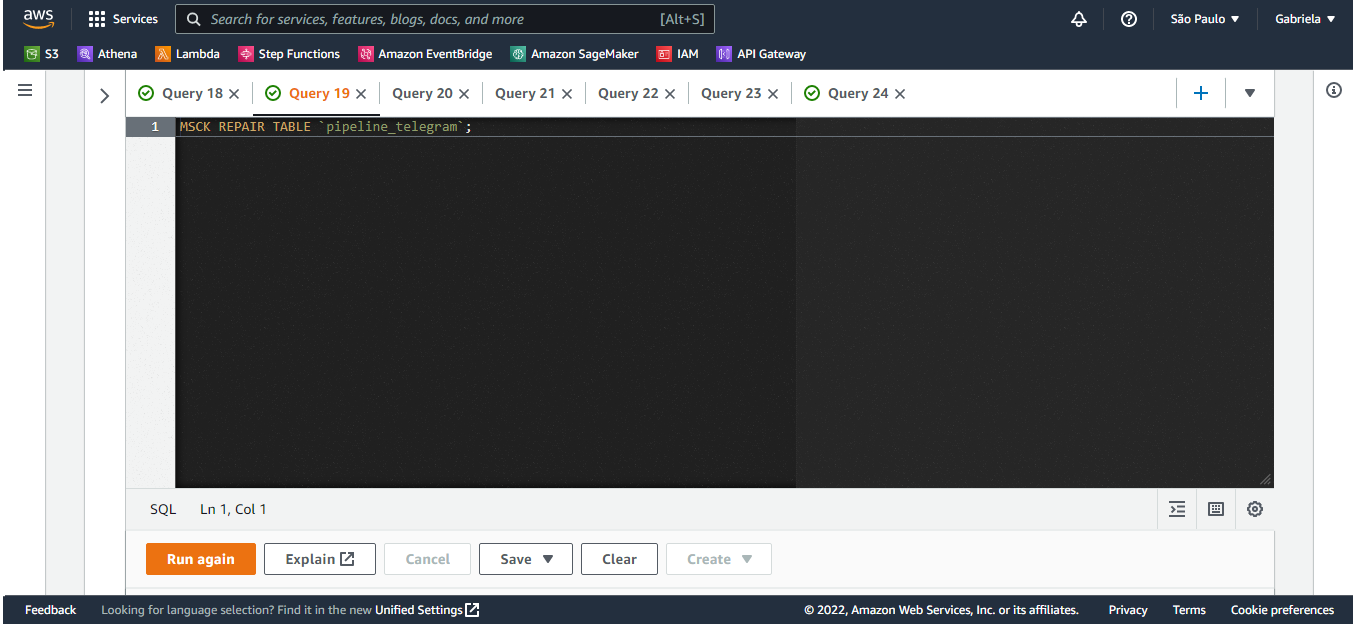

Para confirmar os resultados, executamos **`SELECT * FROM`** 

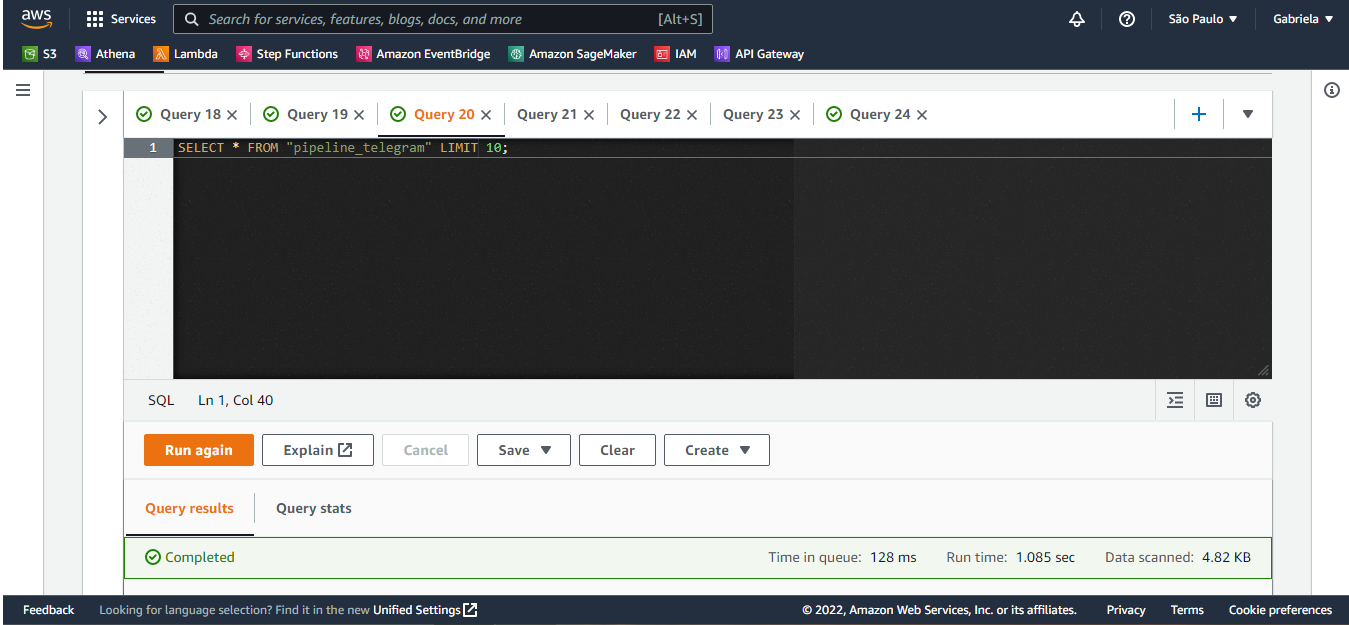

Com o download dos resultados do **`SELECT * FROM`**, podemos observar no dataframe que os dados ficam armazenados de uma forma fácil, que simplifica a  visualização e manipulação das informações pelos profissionais da área.

In [ ]:
#carregando os resultados em um dataframe

august29_data = pd.read_csv("august29.csv", sep=',')
august29_data.sort_values(by=['context_date'], ascending=False).head()

,message_id,user_id,user_is_bot,user_first_name,chat_id,chat_type,text,date,context_date
43,122,5607093956,False,Gabi,-1001609700028,supergroup,oláá,1661794166,2022-08-29
52,131,5607093956,False,Gabi,-1001609700028,supergroup,boa semana pra nós!,1661798754,2022-08-29
44,123,5607093956,False,Gabi,-1001609700028,supergroup,só pra avisar que a aplicação ta 100% funcionando,1661794180,2022-08-29
56,135,5688260145,False,Roberta,-1001609700028,supergroup,Beijos!!!,1661802192,2022-08-29
55,134,5688260145,False,Roberta,-1001609700028,supergroup,Uma boa semana pra vcs!!!,1661802162,2022-08-29


## **3. Análise Exploratória dos Dados**

Com os dados armazenados, limpos e processados, podemos fazer algumas análises com as consultas **`SQL`** no **AWS Athena** e responder algumas questões pertinentes para contratantes dos serviços de **`chatbots`**.

In [ ]:
#pacotes e bibliotecas para visualização dos dados

import seaborn as sns
import matplotlib.pyplot as plt

**1. Qual o total de mensagens recebidas em cada dia?**

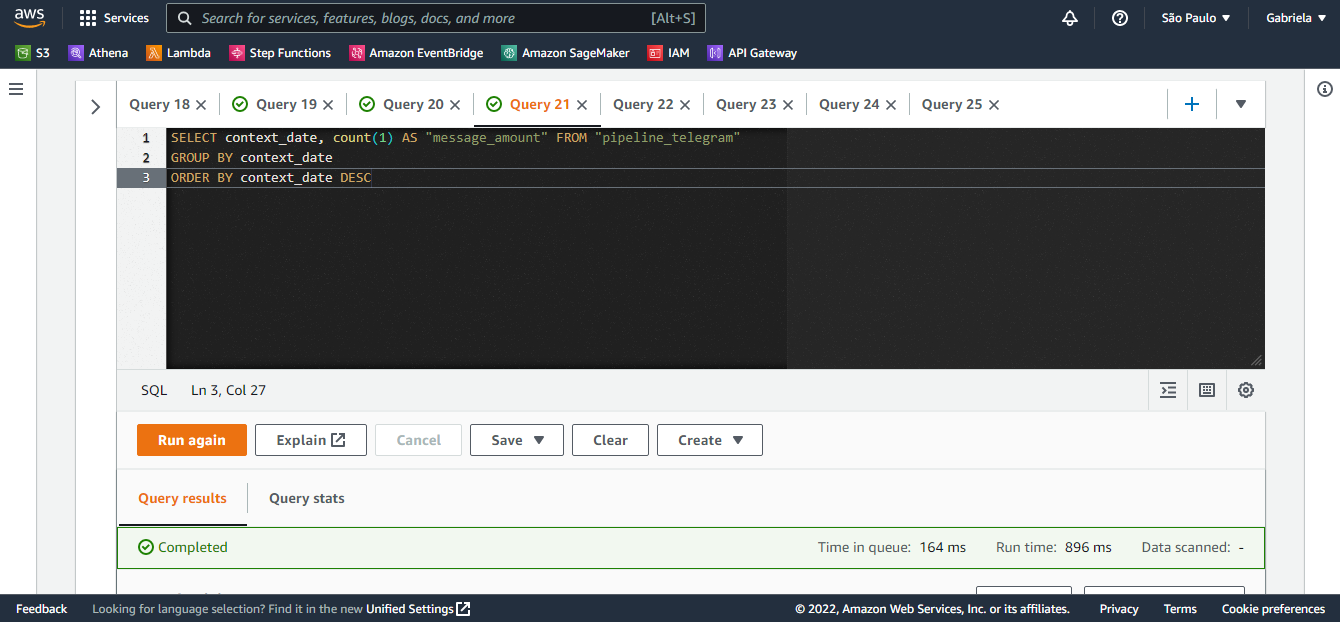

In [ ]:
#carregando os resultados em um dataframe

message_amount = pd.read_csv("totalmensagens.csv", sep=",")
message_amount = message_amount.sort_values(by=['context_date'], ascending=True)
message_amount.head()

,context_date,message_amount
4,2022-08-22,4
3,2022-08-24,5
2,2022-08-26,71
1,2022-08-28,20
0,2022-08-29,14


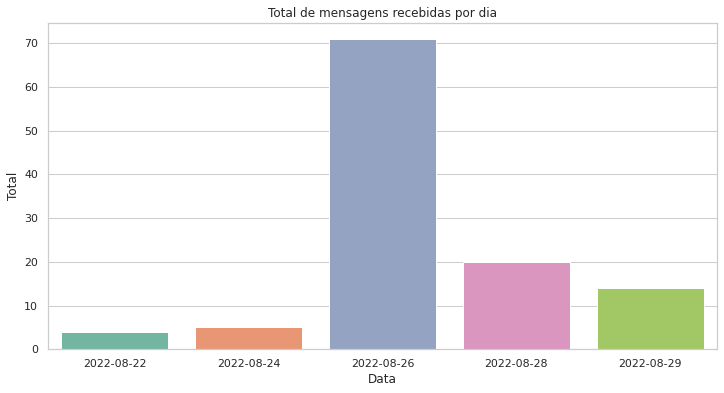

In [ ]:
#construindo um gráfico de barras para visualização dos dados

sns.set_theme(style='whitegrid')

grafico = sns.barplot(data=message_amount, x='context_date', y='message_amount',ci=None, palette='Set2')
grafico.set(title='Total de mensagens recebidas por dia', xlabel='Data', ylabel='Total');
sns.set(rc = {'figure.figsize':(10,6)})

O dia que o **`chatbot`** mais recebeu mensagens foi o dia **26-08-2022**,  **sexta-feira**. Com este tipo de análise podemos saber se existe algum dia da semana ou fim de semana em que os clientes/usuários mais acionam o **`chatbot`**, e relacionar com o período do mês e do ano para tentar entender se existe uma demanda equilibrada entre os dias, ou existe algum período de tempo em que existe uma maior utilização dos **`chatbots`**.

**2. Qual o total de mensagens enviadas por cada usuário, por dia?**

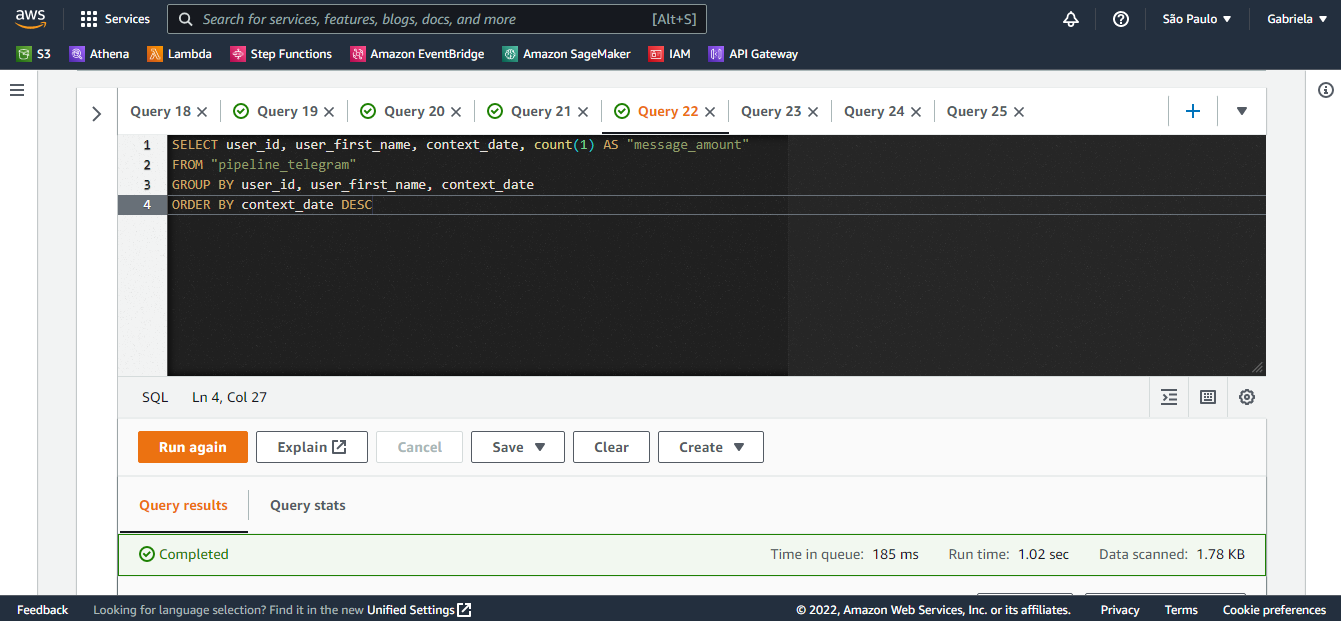

In [ ]:
#carregando os resultados em um dataframe

message_amount_users = pd.read_csv("totalmensagensporusuario.csv", sep=",")
message_amount_users.sort_values(by=['context_date'], ascending=True).head()


,user_id,user_first_name,context_date,message_amount
15,5607093956,Gabi,2022-08-22,4
13,5602449052,Lucy,2022-08-24,1
14,5607093956,Gabi,2022-08-24,4
9,5607093956,Gabi,2022-08-26,32
10,5602449052,Lucy,2022-08-26,9


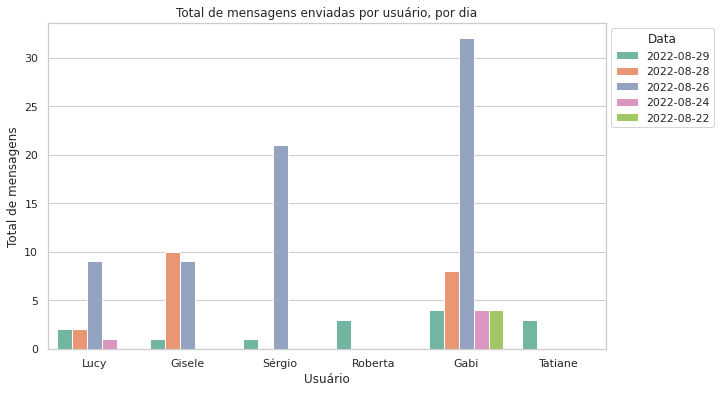

In [ ]:
#construindo um gráfico de barras para visualização dos dados

sns.set_theme(style='whitegrid')

grafico = sns.barplot(data=message_amount_users, x='user_first_name', y='message_amount', hue='context_date', palette='Set2')
grafico.set(title='Total de mensagens enviadas por usuário, por dia', xlabel='Usuário', ylabel='Total de mensagens');
grafico.legend(title='Data', loc=2, bbox_to_anchor = (1,1));


A partir dessa pergunta, podemos analisar a quantidade de usuários/clientes que estão acionando o **`chatbot`** por vários dias e a quantidade de mensagens que eles estão enviando. Se os mesmos usuários estão enviando muitas mensagens durante muitos dias, talvez o **`chatbot`** precise ser reavaliado para garantir que a dúvida ou problema daquela(s) pessoa(s) esteja sendo resolvida.

**3. Qual a média do tamanho das mensagens que os usuários enviam por dia?**

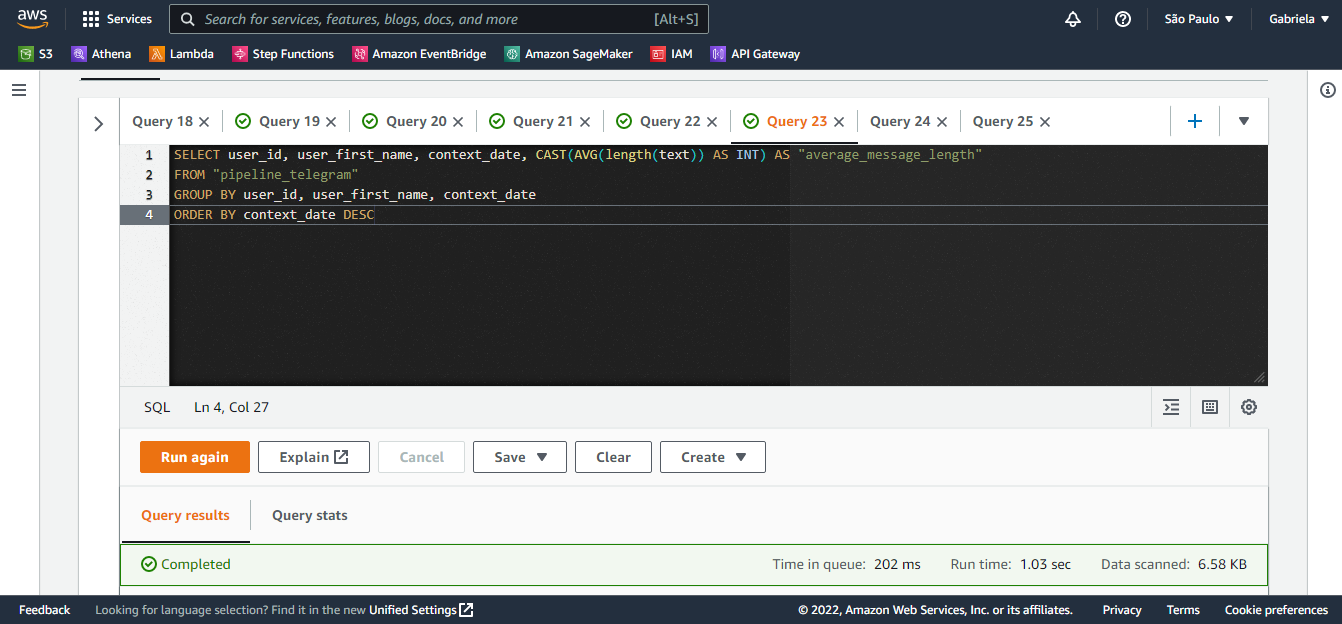

In [ ]:
#carregando os dados em um dataframe

avarage_message_users = pd.read_csv("tamanhomensagens.csv", sep=",")
avarage_message_users.sort_values(by=['context_date'], ascending=True).head()

,user_id,user_first_name,context_date,average_message_length
15,5607093956,Gabi,2022-08-22,32
13,5602449052,Lucy,2022-08-24,23
14,5607093956,Gabi,2022-08-24,15
9,5607093956,Gabi,2022-08-26,48
10,5626527634,Gisele,2022-08-26,13


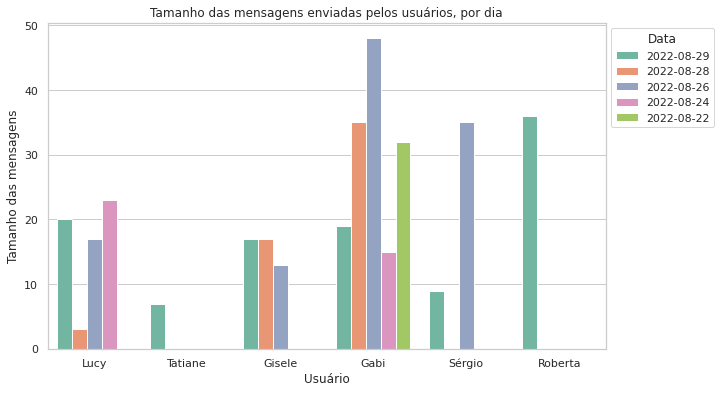

In [ ]:
#construindo um gráfico de barras para visualização dos dados

sns.set_theme(style='whitegrid')

grafico = sns.barplot(data=avarage_message_users, x='user_first_name', y='average_message_length', hue='context_date', palette='Set2')
grafico.set(title='Tamanho das mensagens enviadas pelos usuários, por dia', xlabel='Usuário', ylabel='Tamanho das mensagens');
grafico.legend(title='Data', loc=2, bbox_to_anchor = (1,1));

Analisando o tamanho das mensagens que os usuários enviam ao **`chatbot`**, podemos entender se ele está compreendendo corretamente as palavras-chaves e intenções dos usuários/clientes e desenvolvendo a interação como programado.

**4. Qual a quantidade de mensagens recebidas por hora, por dia da semana, por número da semana no ano?**

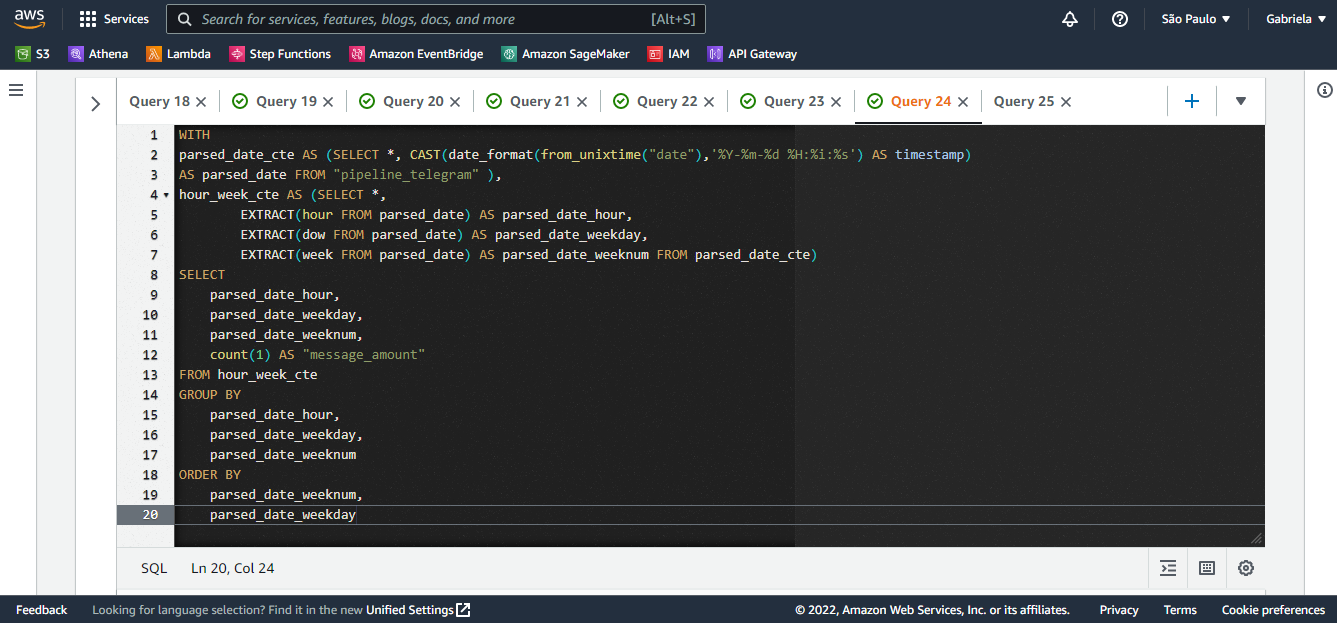

In [ ]:
#carregando os resultados em um dataframe

parsed_date = pd.read_csv("timestamp.csv", sep=",")
parsed_date.head()

,parsed_date_hour,parsed_date_weekday,parsed_date_weeknum,message_amount
0,19,1,34,4
1,17,3,34,1
2,15,3,34,4
3,18,5,34,60
4,20,5,34,2


- Os dias da semana (***parsed_date_weekday***) representados por números são:

  - **1** - segunda-feira;
  - **2** - terça-feira;
  - **3** - quarta-feira;
  - **4** - quinta-feira;
  - **5** - sexta-feira;
  - **6** - sábado;
  - **7** - domingo.

- As semanas do ano (***parsed_date_weeknum***) representadas por números, são equivalentes a contagem desde o primeiro dia do ano, sendo assim:

 -  **1** - primeira semana do ano;
 -  **2** - segunda semana do ano;
 -  **3** - terceira semana do ano;
 - ...
 -  **34** - trigésima quarta semana do ano. 



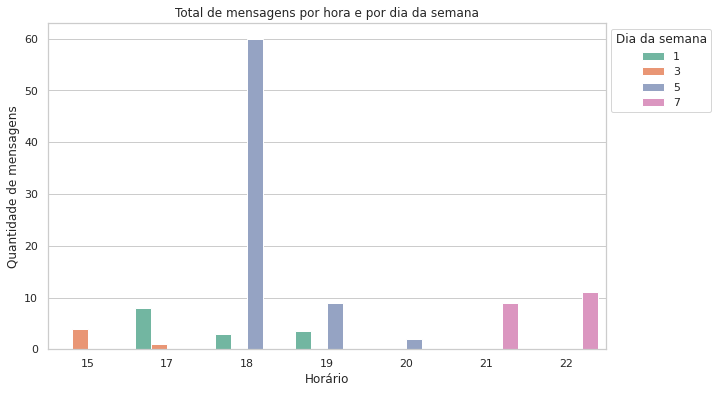

In [ ]:
#construindo um gráfico de barras para visualização dos dados

sns.set_theme(style='whitegrid')

grafico = sns.barplot(data=parsed_date, x='parsed_date_hour', y='message_amount', hue='parsed_date_weekday',ci = None, palette='Set2')
grafico.set(title='Total de mensagens por hora e por dia da semana', xlabel='Horário', ylabel='Quantidade de mensagens');
grafico.legend(title='Dia da semana', loc=2, bbox_to_anchor = (1,1));

A análise acima nos permite mapear o dia da semana, o horário e qual momento do ano usuários/clientes mais acionam os **`chatbots`**, garantindo assim que a aplicação esteja pronta para funcionar em alta demanda. Também podemos observar o comportamento dos clientes/usuários ao longo do ano e tirar insights valiosos de acordo com seus comportamentos em períodos de promoção de produtos ou grandes compras, como nas festas de fim de ano, por exemplo. 

## **4. Conclusão**

A utilização de **`chatbots`** juntamente com a análise dos dados extraídos através de um ***pipeline***, são de grande utilidade para empresas de todo porte, como demonstrado acima. Os **`chatbots`** facilitam a interação dos clientes com a empresa, uma vez que podem resolver problemas e tirar dúvidas pelo seu *smarphone/web* sem precisar ir até uma loja ou entrar em contato diretamente com algum funcionário. Os dados extraídos dessas interações fornecem ***insights*** de grande valor para os tomadores de decisão, uma vez que as análises personalizadas de acordo com suas demandas, fornecem informações que vão desde o comportamento dos seus clientes, até esclarecimentos e feedbacks sobre os produtos oferecidos.

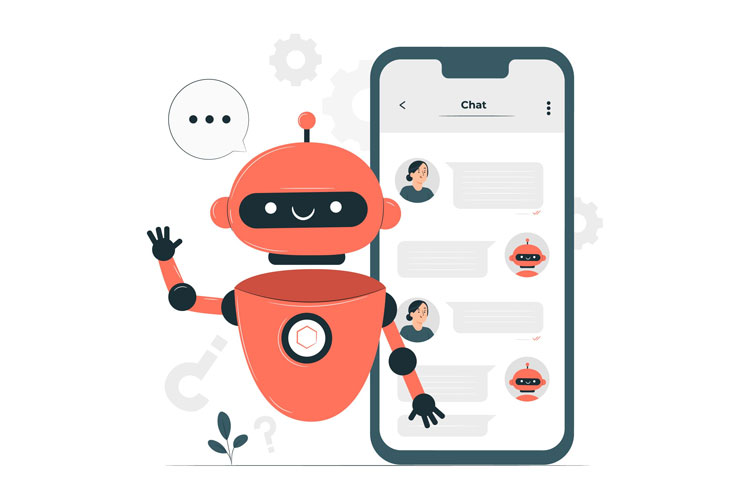


Fonte [imagem](https://www.agenciaeplus.com.br/5-ferramentas-de-chatbot/).